In [1]:
%matplotlib inline
import numpy as np
import math
import matplotlib.pyplot as plt
import scipy.stats as st

In this notebook I practice several concepts related to linear regression and least squares. In order to do so I need a function to create data with linear trend. The following function creates a randomized dataset from the parameters of a linear regression model (slope and intercept.)

In [2]:
SIZE = 100
def generate_random_linear_sample(slope, intercept, noise_std, x_init, x_end):
    x = np.random.uniform(x_init, x_end, SIZE)
    y = x*slope + intercept + np.random.normal(0, noise_std, SIZE)
    
    return (x,y)

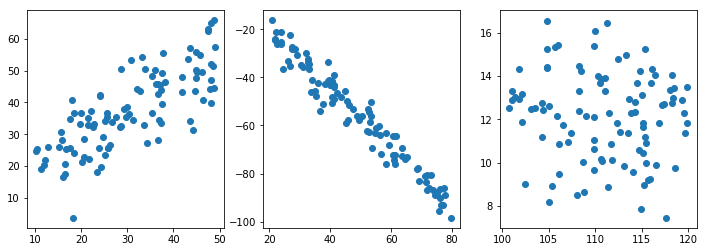

In [3]:
x1, y1 = generate_random_linear_sample(0.85, 12, 8, 10, 50)
x2, y2 = generate_random_linear_sample(-1.23, 5, 5, 20, 80)
x3, y3 = generate_random_linear_sample(0.02, 10, 2, 100, 120)
fig, ax = plt.subplots(1,3)
ax[0].scatter(x1, y1)
ax[1].scatter(x2, y2)
ax[2].scatter(x3, y3)
fig.set_figwidth(12)

### Example of moderate positive linear relationship

Correlation is a measure of the strength of the linear relationship between two variables. The correlation value is in the range between -1 and 1. If the variables have a strong positive linear relationship the value is close to one. If the variables have a strong negative relationship the value is closer to minus one. If there is no apparent linear relationship between the variables the value will be close to zero. 

Correlation demonstrates a positive linear relationship for the set of observations (x1, y1):

In [4]:
R = 1/(len(x1) - 1)*np.sum((x1 - np.mean(x1))*(y1 - np.mean(y1))/(np.std(x1) * np.std(y1)))
print(R)

0.783850067519


Least squares is a method to fit a linar model based on minimising the least squares criterion, that is, the square of the residuals. The residual of an observation is the difference between the observed value of the response variable and the value predicted by the linear model.

Let's apply least squares to the set of observations (x1, y1):

In [5]:
b1 = R * np.std(y1) / np.std(x1)
b0 = np.mean(y1) - b1 * np.mean(x1)

print('y = {0} * x + {1}'.format(b1, b0))

y = 0.8483620797411882 * x + 11.532944949231183


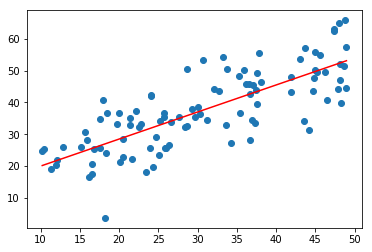

In [6]:
def predict(x, b0, b1):
    return(b0 + b1*x)

fig, ax = plt.subplots()
ax.scatter(x1, y1)
ax.plot([np.min(x1), np.max(x1)], [predict(np.min(x1), b0, b1), predict(np.max(x1), b0, b1)], 'r')

In order to apply least squares, we have to check the following conditions:

- The data has a linear trend
- The distribution of the residuals is normal. This may not be the case if there are outliers
- The variability of the data around the line has to remain constant
- The observations are independent. That is not the case, for instance, when we have time series data.

In order to test these conditions we generate a series of plots:

In [7]:
def test_conditions(x, y, b0, b1):
    fig, ax = plt.subplots(2,2)
    
    predictions = x*b1 + b0
    residuals = y - predictions
    
    # Residuals plot
    ax[0][0].scatter(x, residuals)
    ax[0][0].plot([np.min(x)-1, np.max(x)+1], [0, 0], 'k--')
    ax[0][0].set_xlabel('x')
    ax[0][0].set_ylabel('residuals')
    
    # Distribution of the residuals
    weights = np.ones_like(residuals)/float(len(residuals))
    ax[0][1].hist(residuals, bins=10, weights=weights)
    ax[0][1].set_xlabel('residuals')
    
    # Q-q plot of the residuals
    quantiles = np.arange(0.01,0.99,0.01)
    q_theoretical = [st.norm.ppf(i, loc=np.mean(residuals), scale=np.std(residuals)) for i in quantiles]
    q_residuals = [np.percentile(residuals, i*100) for i in quantiles]
    ax[1][0].scatter(q_residuals, q_theoretical, color='blue')
    min_value = min(np.min(q_theoretical), np.min(q_residuals))
    max_value = max(np.max(q_theoretical), np.max(q_residuals))
    ax[1][0].plot([min_value, max_value], [min_value, max_value], 'k--')
    ax[1][0].set_xlabel('residuals')
    ax[1][0].set_ylabel('theoretical')
    
    # Order of data collection
    ax[1][1].scatter(range(len(x)), residuals)
    ax[1][1].plot([0, len(x)], [0, 0], 'k--')
    ax[1][1].set_xlabel('order of data collection')
    ax[1][1].set_ylabel('residuals')
    
    fig.set_figwidth(12)
    fig.set_figheight(8)

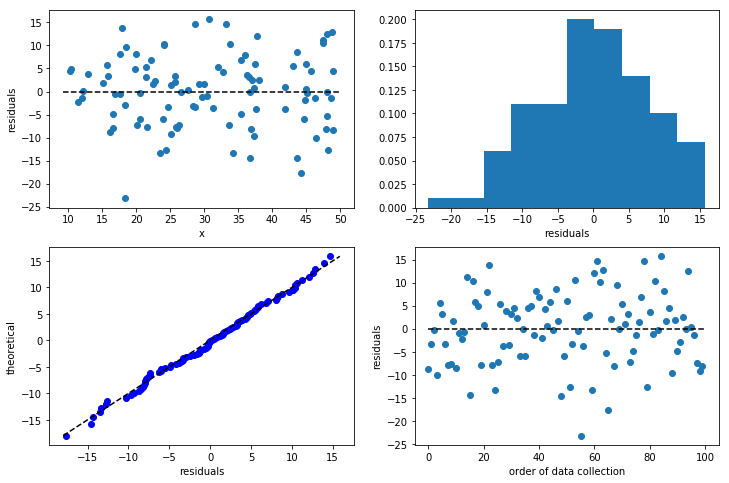

In [8]:
test_conditions(x1, y1, b0, b1)

These plots demonstrate that least squares can be applied to the (x1, y1) dataset.

Another measure to analyse the strenght of the linear relationship between two variables is R^2. R^2 is a measure of how much variability of the response variable is explained by the fitted linear model. It can be calculated from the standard deviation of the response variable values of the observations and the standard deviation of the residuals. It can also be calculated as the square of the correlation.

In [9]:
predictions = x1*b1 + b0
residuals = y1 - predictions

R_2 = (np.std(y1)**2 - np.std(residuals)**2)/np.std(y1)**2
print('{}% of the variability of y is explained by the fitted linear model'.format(R_2*100))
print(R**2)

60.21325097819822% of the variability of y is explained by the fitted linear model
0.614420928349


We can apply a one-sample t-test to determine whether there is enough evidence in the data to support the idea that the slope of the fitted linear model is different than zero. We will carry out a one-sided test. The hypotheses are:

```
H0: beta_1 = 0
HA: beta_1 > 0
```

In [10]:
SE_regression = math.sqrt(np.sum((y1 - predictions)**2)/(len(x1)-2))
SE_b1 = SE_regression / math.sqrt(np.sum((x1 - np.mean(x1))**2))
print('SE_b1 = ' + str(SE_b1))

t = b1/SE_b1
print('T-score = ' + str(t))

p_value = 1 - st.t(loc=0, scale=SE_b1, df=len(x1)-2).cdf(t)
print('p-value = ' + str(p_value))

SE_b1 = 0.06896114081372462
T-score = 12.302030821
p-value = 0.0


The p-value is lower than 0.05, so we reject the null hypothesis. 

In [11]:
print('CI = [{0}, {1}]'.format(b1-SE_b1*st.t.ppf(0.95, len(x1)-2), b1+SE_b1*st.t.ppf(0.95, len(x1)-2)))

CI = [0.7338485734342112, 0.9628755860481651]


The 95% confidence interval supports the results of the hypothesis test, because it does not contain the value zero. 

### Example of strong negative linear relationship

Correlation demonstrates a negative linear relationship for the set of observations (x2, y2):

In [12]:
R = 1/(len(x2) - 1)*np.sum((x2 - np.mean(x2))*(y2 - np.mean(y2))/(np.std(x2) * np.std(y2)))
print(R)

-0.986425227404


Let's apply least squares to the set of observations (x2, y2):

In [13]:
b1 = R * np.std(y2) / np.std(x2)
b0 = np.mean(y2) - b1 * np.mean(x2)

print('y = {0} * x + {1}'.format(b1, b0))

y = -1.2243406710545615 * x + 4.014943648321875


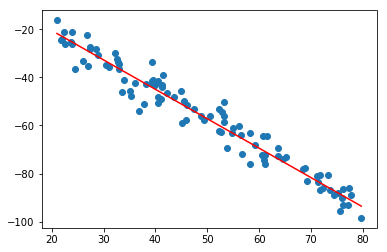

In [14]:
fig, ax = plt.subplots()
ax.scatter(x2, y2)
ax.plot([np.min(x2), np.max(x2)], [predict(np.min(x2), b0, b1), predict(np.max(x2), b0, b1)], 'r')

Let's test the least squares conditions:

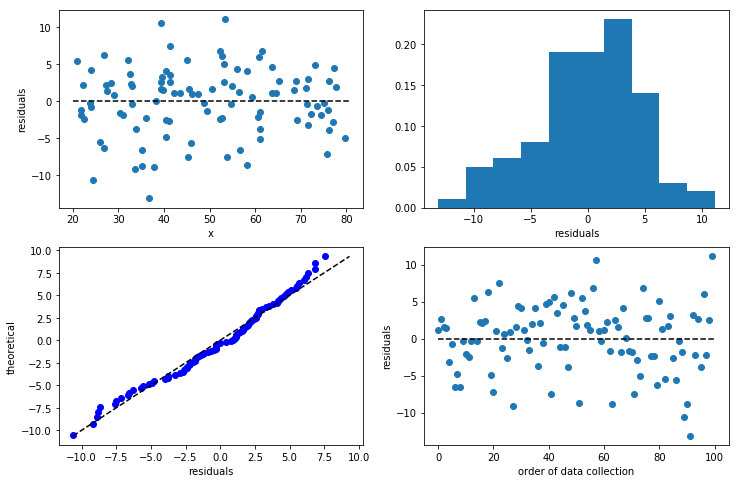

In [15]:
test_conditions(x2, y2, b0, b1)

These plots demonstrate that least squares can be applied to the (x2, y2) dataset.

In [16]:
predictions = x2*b1 + b0
residuals = y2 - predictions

R_2 = (np.std(y2)**2 - np.std(residuals)**2)/np.std(y2)**2
print('{}% of the variability of y is explained by the fitted linear model'.format(R_2*100))
print(R**2)

95.35740346742068% of the variability of y is explained by the fitted linear model
0.973034729259


Carrying out a one-sided one-sample t-test to determine whether there is evidence in the data to support the statement that the slope is different than zero:

```
H0: beta_1 = 0
HA: beta_1 < 0
```

In [17]:
SE_regression = math.sqrt(np.sum((y2 - predictions)**2)/(len(x2)-2))
SE_b1 = SE_regression / math.sqrt(np.sum((x2 - np.mean(x2))**2))
print('SE_b1 = ' + str(SE_b1))

t = b1/SE_b1
print('T-score = ' + str(t))

p_value = st.t(loc=0, scale=SE_b1, df=len(x2)-2).cdf(t)
print('p-value = ' + str(p_value))

SE_b1 = 0.027015035298048842
T-score = -45.3207133564
p-value = 1.42493774729e-220


The p-value is lower than 0.05, so we reject the null hypothesis.

In [18]:
print('CI = [{0}, {1}]'.format(b1-SE_b1*st.t.ppf(0.95, len(x2)-2), b1+SE_b1*st.t.ppf(0.95, len(x2)-2)))

CI = [-1.2692005207972246, -1.1794808213118984]


The 95% confidence interval supports the results of the hypothesis test, because it does not contain the value zero. 

### Example of very weak linear relationship

Correlation demonstrates that there is no linear relationship for the ser of observations (x3, y3):

In [19]:
R = 1/(len(x3) - 1)*np.sum((x3 - np.mean(x3))*(y3 - np.mean(y3))/(np.std(x3) * np.std(y3)))
print(R)

-0.111169013782


Let's apply least squares to the set of observations (x3, y3):

In [20]:
b1 = R * np.std(y3) / np.std(x3)
b0 = np.mean(y3) - b1 * np.mean(x3)

print('y = {0} * x + {1}'.format(b1, b0))

y = -0.04224233702999986 * x + 16.84856440385423


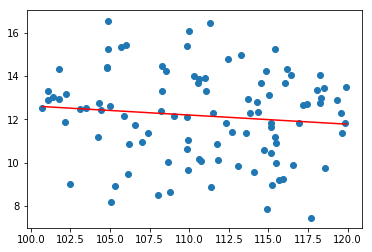

In [21]:
fig, ax = plt.subplots()
ax.scatter(x3, y3)
ax.plot([np.min(x3), np.max(x3)], [predict(np.min(x3), b0, b1), predict(np.max(x3), b0, b1)], 'r')

Let's test the least squares conditions:

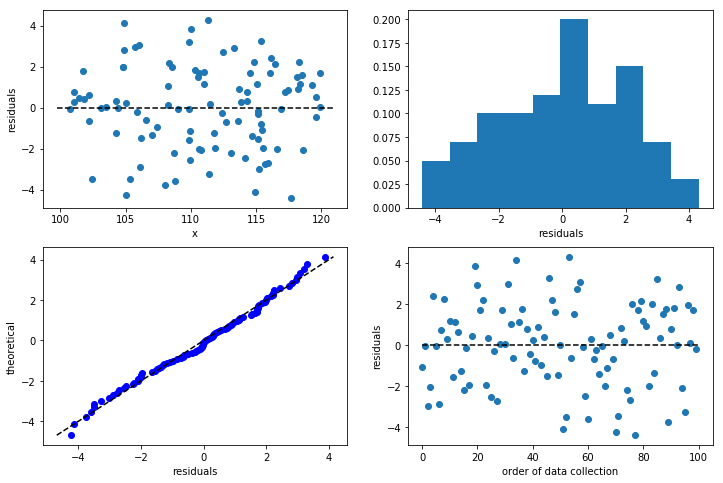

In [22]:
test_conditions(x3, y3, b0, b1)

These plots demonstrate that least squares can be applied to the (x3, y3) dataset. The linear trend is practically non-existent, but the rest of the conditions apply. 

In [23]:
predictions = x3*b1 + b0
residuals = y3 - predictions

R_2 = (np.std(y3)**2 - np.std(residuals)**2)/np.std(y3)**2
print('{}% of the variability of y is explained by the fitted linear model'.format(R_2*100))
print(R**2)

1.2111378632769791% of the variability of y is explained by the fitted linear model
0.0123585496253


Carrying out a one-sided one-sample t-test to determine whether there is evidence in the data to support the statement that the slope is different than zero:

```
H0: beta_1 = 0
HA: beta_1 > 0
```

In [24]:
SE_regression = math.sqrt(np.sum((y3 - predictions)**2)/(len(x3)-2))
SE_b1 = SE_regression / math.sqrt(np.sum((x3 - np.mean(x3))**2))
print('SE_b1 = ' + str(SE_b1))

t = b1/SE_b1
print('T-score = ' + str(t))

p_value = st.t(loc=0, scale=SE_b1, df=len(x3)-2).cdf(t)
print('p-value = ' + str(p_value))

SE_b1 = 0.038150930785626716
T-score = -1.10724263236
p-value = 3.2153849786e-50


In this case the p-value is higher than 0.05, so we fail to reject the null hypothesis. There's no evidence in the data that the slope is higher than zero. 

In [25]:
print('CI = [{0}, {1}]'.format(b1-SE_b1*st.t.ppf(0.95, len(x2)-2), b1+SE_b1*st.t.ppf(0.95, len(x2)-2)))

CI = [-0.10559391157743589, 0.02110923751743616]


The 95% confidence interval supports the results of the hypothesis test, because in this case it does contain the value zero.